In [1]:
from pathlib import Path

import astropy.units as u
from lunarsky import Time, MoonLocation
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import lusee_faraday as ld

%matplotlib widget

In [2]:
DATA_DIR = Path("/home/christian/Documents/research/lusee/lusee_faraday/data/")
NSIDE = 128
FREQ = 30

fzoom = ld.utils.freqs_zoom(center=FREQ)
print((fzoom[1]-fzoom[0])*1e6)
nfreqs = fzoom.size
print(nfreqs)

390.6250000014211
64


In [3]:
beam_file = DATA_DIR / "hfss_lbl_3m_75deg.2port.fits"
lusee_beam = ld.Beam.from_file(beam_file, frequency=FREQ, nside=NSIDE)
lusee_beam.precompute_weights()

In [4]:
wmap_23ghz = ld.sky.load_wmap(DATA_DIR / "wmap_band_iqumap_r9_9yr_K_v5.fits", nside=NSIDE)
wmap = ld.sky.power_law(wmap_23ghz, fzoom, 23e3)
rm = ld.sky.load_rm(DATA_DIR / "faraday2020v2.hdf5")

In [5]:
sky = ld.SkyModel(wmap[:, 0], wmap[:, 1], wmap[:, 2], rm, freq=fzoom, frame="galactic")
print(sky.frame, sky.freq)

galactic [30.         30.00039063 30.00078125 30.00117188 30.0015625  30.00195312
 30.00234375 30.00273437 30.003125   30.00351562 30.00390625 30.00429688
 30.0046875  30.00507813 30.00546875 30.00585938 30.00625    30.00664062
 30.00703125 30.00742188 30.0078125  30.00820313 30.00859375 30.00898438
 30.009375   30.00976562 30.01015625 30.01054687 30.0109375  30.01132813
 30.01171875 30.01210938 30.0125     30.01289063 30.01328125 30.01367188
 30.0140625  30.01445313 30.01484375 30.01523438 30.015625   30.01601563
 30.01640625 30.01679688 30.0171875  30.01757812 30.01796875 30.01835938
 30.01875    30.01914063 30.01953125 30.01992188 30.0203125  30.02070313
 30.02109375 30.02148438 30.021875   30.02226563 30.02265625 30.02304688
 30.0234375  30.02382813 30.02421875 30.02460938]


In [6]:
lusee_loc = MoonLocation(lat=-23.813, lon=182.258)
time_start = Time("2027-01-01T09:00:00", location=lusee_loc)
time_end = time_start + 655.720 * 3600 * u.s
print(time_end)
times = np.linspace(time_start, time_end, num=100, endpoint=False)

cfg = ld.SimConfig(freqs=fzoom, times=times, sky=sky, beam=lusee_beam, nside=NSIDE, faraday=True)
sim = ld.Simulator(cfg)
vis = sim.simulate()  # shape is ntimes, 3, nfreqs

2027-01-28T16:43:12.000
Simulating time step 1 of 100


/home/christian/Documents/research/lusee/lusee_faraday/src/lusee_faraday/sim.py:162: ComplexWarning: Casting complex values to real discards the imaginary part
  res[i] = R_t


Simulating time step 2 of 100
Simulating time step 3 of 100
Simulating time step 4 of 100
Simulating time step 5 of 100
Simulating time step 6 of 100
Simulating time step 7 of 100
Simulating time step 8 of 100
Simulating time step 9 of 100
Simulating time step 10 of 100
Simulating time step 11 of 100
Simulating time step 12 of 100
Simulating time step 13 of 100
Simulating time step 14 of 100
Simulating time step 15 of 100
Simulating time step 16 of 100
Simulating time step 17 of 100
Simulating time step 18 of 100
Simulating time step 19 of 100
Simulating time step 20 of 100
Simulating time step 21 of 100
Simulating time step 22 of 100
Simulating time step 23 of 100
Simulating time step 24 of 100
Simulating time step 25 of 100
Simulating time step 26 of 100
Simulating time step 27 of 100
Simulating time step 28 of 100
Simulating time step 29 of 100
Simulating time step 30 of 100
Simulating time step 31 of 100
Simulating time step 32 of 100
Simulating time step 33 of 100
Simulating time 

In [7]:
pI, pQ, pU = sim.compute_stokes(vis)

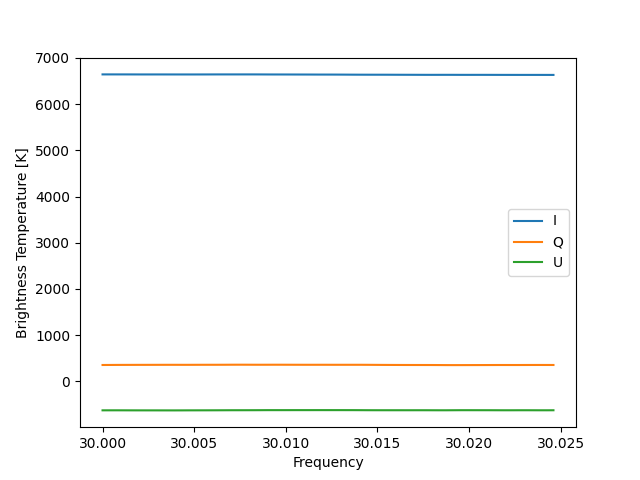

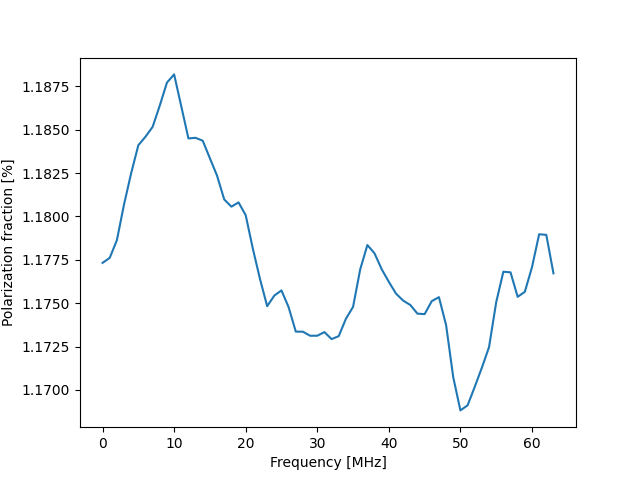

In [8]:
plt.figure()
plt.plot(fzoom, pI[0], label="I")
plt.plot(fzoom, pQ[0], label="Q")
plt.plot(fzoom, pU[0], label="U")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Brightness Temperature [K]")
plt.show()

plt.figure()
plt.plot(100*((pQ**2 + pU**2)/pI**2)[0], label="Pol fraction")
plt.ylabel("Polarization fraction [%]")
plt.xlabel("Frequency [MHz]")
plt.show()

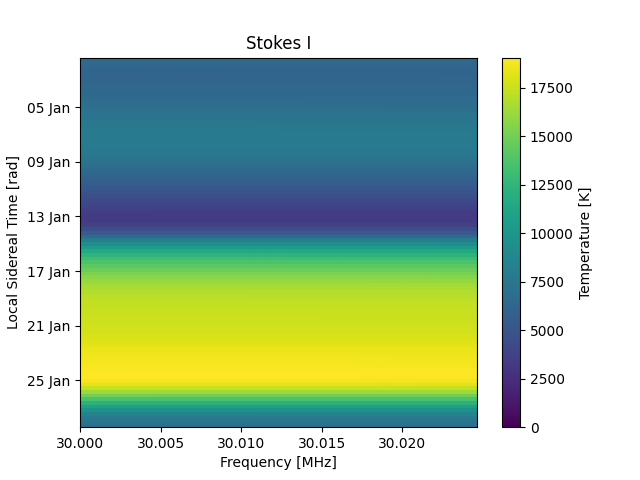

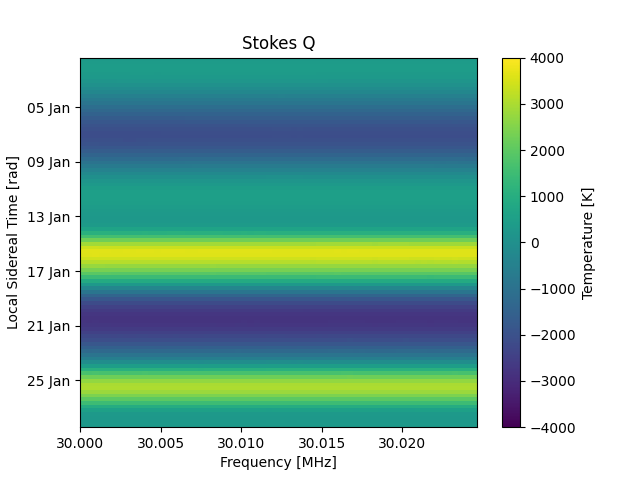

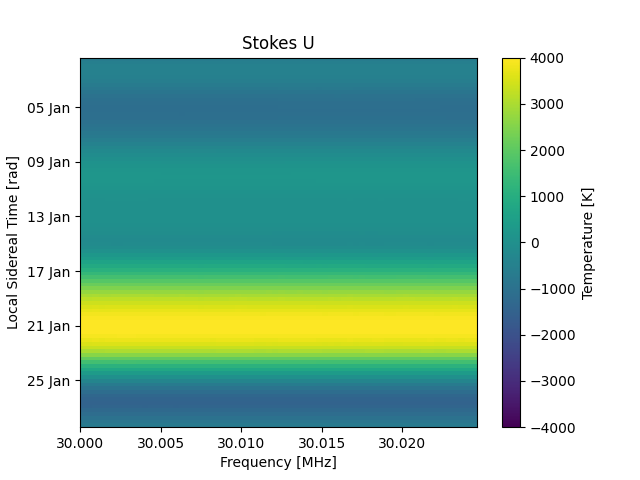

In [12]:
def waterfall(arr, title=None, vmin=None, vmax=None):
    plt.figure()
    plt.imshow(arr, aspect="auto", extent=[fzoom[0], fzoom[-1], times[-1].to_datetime(), times[0].to_datetime()], vmin=vmin, vmax=vmax)
    plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Local Sidereal Time [rad]")
    plt.colorbar(label="Temperature [K]")
    if title:
        plt.title(title)
    plt.show()

waterfall(pI, title="Stokes I", vmin=0)
waterfall(pQ, title="Stokes Q", vmin=-4000, vmax=4000)
waterfall(pU, title="Stokes U", vmin=-4000, vmax=4000)

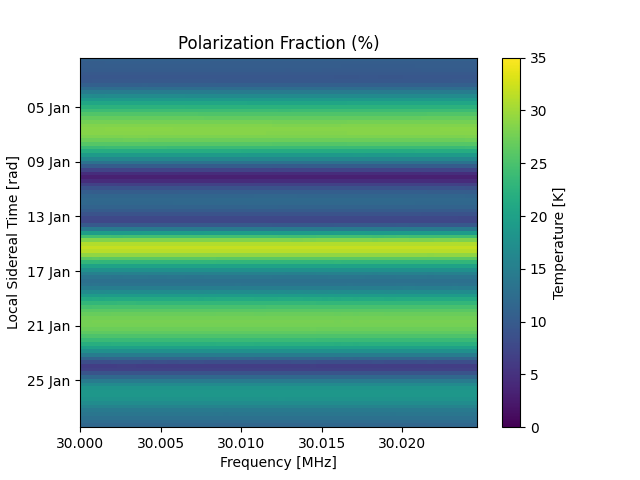

In [15]:
pol_frac = np.sqrt(pQ**2 + pU**2) / pI

waterfall(pol_frac*100, title="Polarization Fraction (%)", vmin=0, vmax=35)

In [36]:
def delay_waterfall(arr, title=None, vmin=None, vmax=None):
    _arr = np.fft.rfft(arr, axis=1)
    tau = np.fft.rfftfreq(fzoom.size, d=fzoom[1]-fzoom[0])
    plt.figure()
    plt.imshow(np.log10(np.abs(_arr)), aspect="auto", extent=[tau[0], tau[-1], times[-1].to_datetime(), times[0].to_datetime()], vmin=vmin, vmax=vmax)
    plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    plt.xlabel("Delay [us]")
    #plt.ylabel("")
    plt.colorbar(label="Log of FT of Temperature [log K]")
    if title:
        plt.title(title)
    plt.show()

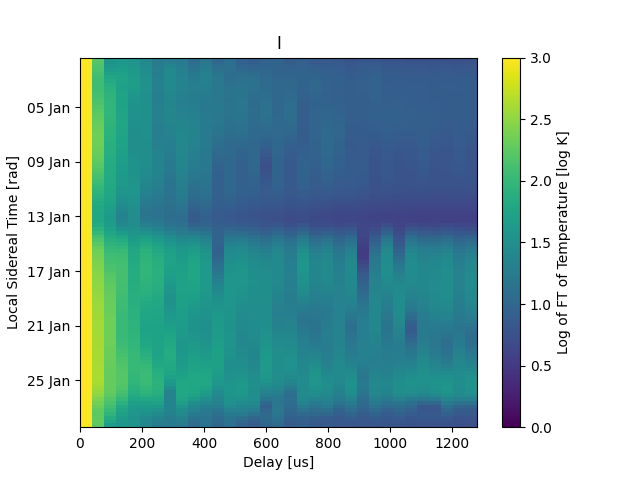

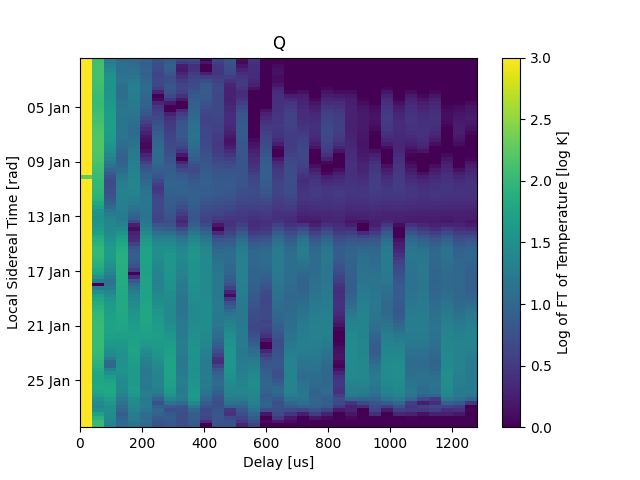

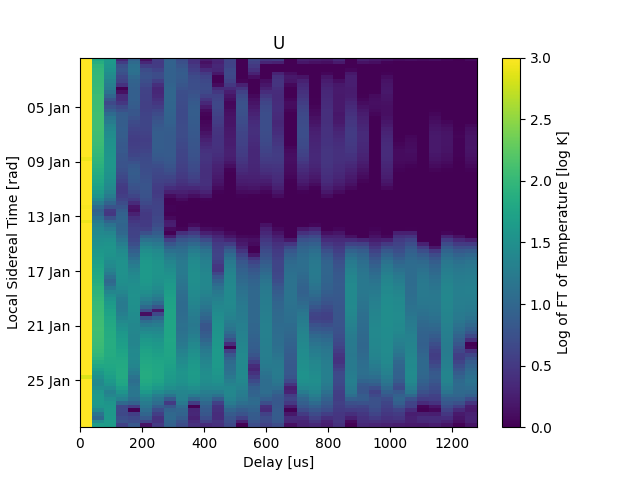

In [38]:
delay_waterfall(pI, title="I", vmin=0, vmax=3)
delay_waterfall(pQ, title="Q", vmin=0, vmax=3)
delay_waterfall(pU, title="U", vmin=0, vmax=3)

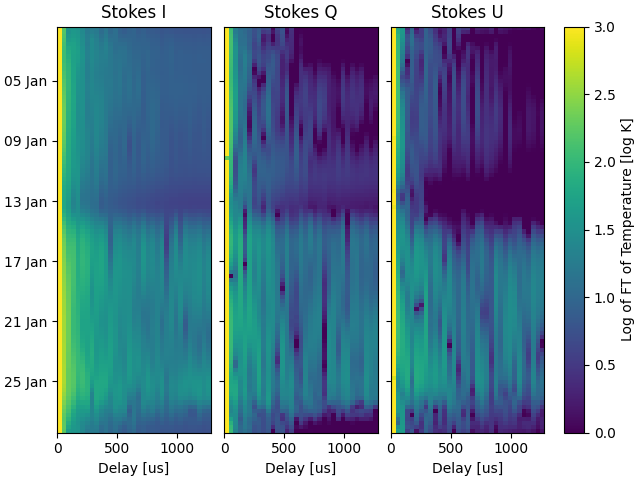

In [43]:
def delay_sub(arrs, titles=["Stokes I", "Stokes Q", "Stokes U"], vmin=0, vmax=3):
    tau = np.fft.rfftfreq(fzoom.size, d=fzoom[1]-fzoom[0])
    extent=[tau[0], tau[-1], times[-1].to_datetime(), times[0].to_datetime()]
    fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, sharex=True, sharey=True)
    for ax, arr, title in zip(axs, arrs, titles):
        _arr = np.fft.rfft(arr, axis=1)
        im = ax.imshow(np.log10(np.abs(_arr)), aspect="auto", extent=extent, vmin=vmin, vmax=vmax)
        ax.yaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
        ax.set_xlabel("Delay [us]")
        ax.set_title(title)
    cbar = fig.colorbar(im, ax=axs, orientation="vertical", fraction=0.8, pad=0.04)
    cbar.set_label("Log of FT of Temperature [log K]")
    plt.show()

delay_sub((pI, pQ, pU))

In [20]:
pI.shape

(100, 64)

In [ ]:
def plot_ft_single(arr, num, title=None, ymin=None, ymax=None):
    _arr = np.fft.rfft(arr, axis=0)
    tau = np.fft.rfftfreq(fzoom.size, d=fzoom[1]-fzoom[0])

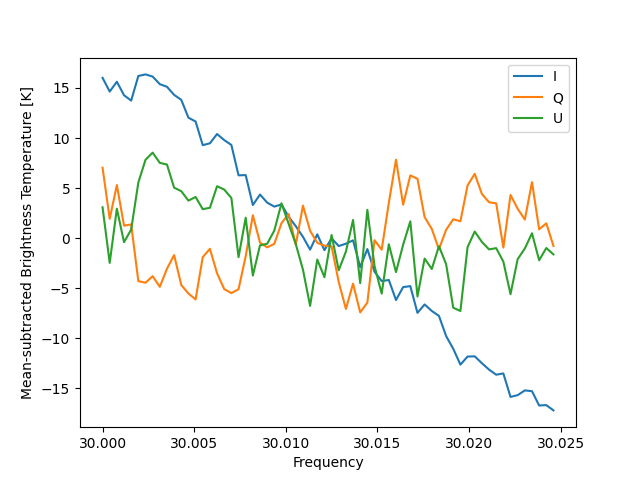

In [13]:
pI_res = pI[0] - pI[0].mean()
pQ_res = pQ[0] - pQ[0].mean()
pU_res = pU[0] - pU[0].mean()

plt.figure()
plt.plot(fzoom, pI_res, label="I")
plt.plot(fzoom, pQ_res, label="Q")
plt.plot(fzoom, pU_res, label="U")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Mean-subtracted Brightness Temperature [K]")
plt.show()

In [17]:
def rms_scale(arr):
    m = arr.mean()
    res = arr - m
    rms = np.sqrt(np.mean(res**2))
    return rms, np.abs(100 * rms/m)

print(rms_scale(pI[0]))
print(rms_scale(pQ[0]))
print(rms_scale(pU[0]))

(np.float64(10.600471021447326), np.float64(0.06039435779016134))
(np.float64(3.822706405914071), np.float64(0.13776211895499857))
(np.float64(3.720285301864265), np.float64(0.09512531927142977))
